# ***Introduction***

In this kernel, I would like to show some descriptive analysis of 'Olist Store' from Brazil. This data contains 100k orders information between 2016-2018.

Above analysis made by orders, geolocation, payments, seller, and products datasets. The aim of this project is finding the Top 10 products and sellers, analysis of orders by their geolocation and obtain information about Brazilian's online e-commerce profiles.

In [1]:
import pandas as pd
import numpy as np
import os
os.getcwd()
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# ***Geo Exploratory***

In [2]:
csv_path = os.path.join('..', 'olist', 'O-list', 'data','csv')
csv_path

'../olist/O-list/data/csv'

In [3]:
geo_data = pd.read_csv(os.path.join(csv_path, 'olist_geolocation_dataset.csv'))

In [4]:
geo_data.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


<AxesSubplot: xlabel='geolocation_state', ylabel='count'>

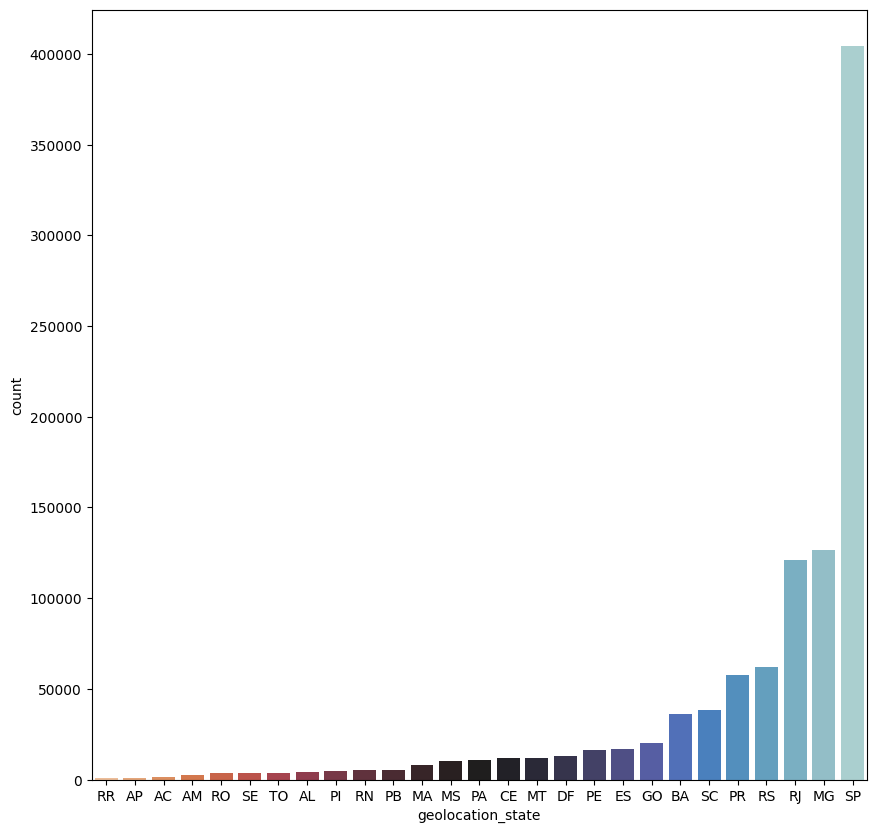

In [5]:
plt.figure(figsize=(10,10))
sns.countplot(x ='geolocation_state', data=geo_data, 
              order=geo_data['geolocation_state'].value_counts().sort_values().index, 
              palette='icefire_r')

The above graph shows the number of product orders purchased based on the states. According to that, São Paulo has the highest rate and there is a huge gap between the rest of the states.

# ***Data Exploratory***

## Order Data

In [6]:
order_data = pd.read_csv(os.path.join(csv_path, 'olist_orders_dataset.csv'))

In [7]:
order_data.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

### Feature Enginering with Time

Since, missing values' proportion is around 3%, Null Values from customer date feature will be filled with forward-fill method. This method propagates the previous value forward.

In [8]:
order_data['order_delivered_customer_date']= order_data['order_delivered_customer_date'].fillna(method='ffill')
order_data['order_delivered_customer_date'].isnull().sum()

0

`Delivered time` and `Estimate time` features will be created.

In [9]:
order_data['delivered_time']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                            format='%Y-%m-%d').dt.date
order_data['estimate_time']=pd.to_datetime(order_data['order_estimated_delivery_date'], 
                                           format='%Y-%m-%d').dt.date

`Weekly` feature created based on `order delivered customer date`

In [10]:
order_data['weekly']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                    format='%Y-%m-%d').dt.week

/var/folders/wc/2q4dwnq93bj7t10_sww8jmv40000gn/T/ipykernel_12742/1618590938.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  order_data['weekly']=pd.to_datetime(order_data['order_delivered_customer_date'],


`Yearly` feature created based on `order delivered customer date`

In [11]:
order_data['yearly']=pd.to_datetime(order_data['order_delivered_customer_date'])\
                    .dt.to_period('M')
order_data['yearly']= order_data['yearly'].astype(str)

Finding different days of delivered and estimated times.

In [12]:
order_data['diff_days']= order_data['delivered_time']-order_data['estimate_time']
order_data['diff_days']= order_data['diff_days'].dt.days

Text(0.5, 1.0, 'Average Difference Days per Week')

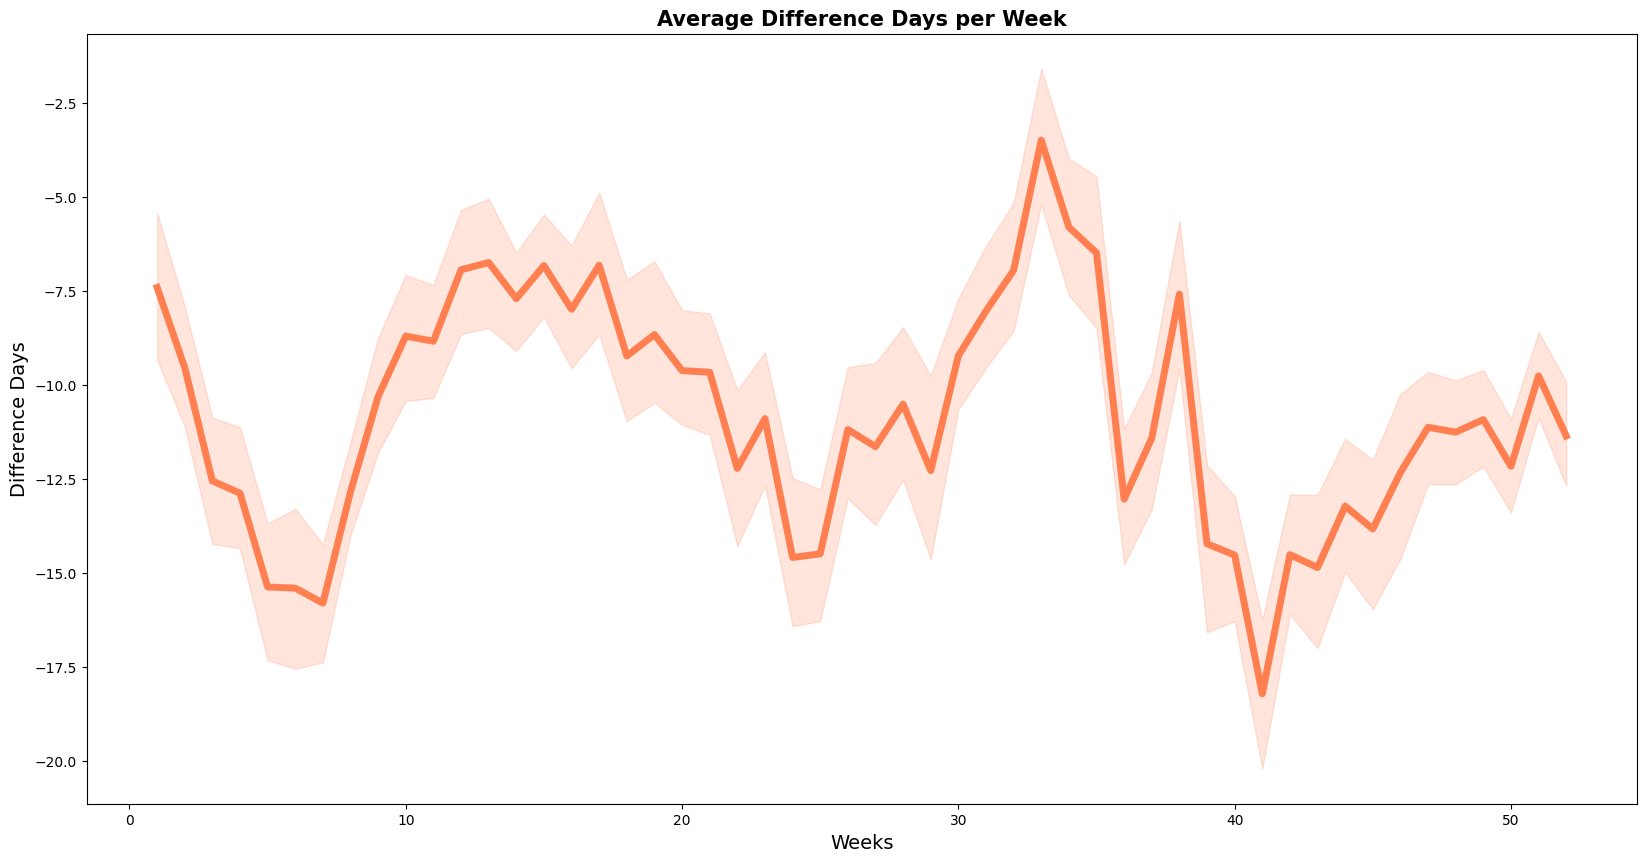

In [13]:
plt.figure(figsize=(20,10))
sns.lineplot(x='weekly', y='diff_days', data=order_data, color="coral", linewidth=5,
            markers=True,dashes=False, estimator='mean')

plt.xlabel("Weeks", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Week",size=15, weight='bold')

Above graph shows the earliest and latest deliveries. According to the graph we can say that all deliveries were made before their estimated date.

The earliest deliveries were made in October. This indicates that this month is the least intensive period in the year.
The latest deliveries were made at the end of June and beginning of August. This indicates that this time is the most intensive period in the year.

## Customer Top 10 Product

☝️ First, Olist_orders and olist_order_items databases need to be joined.

In [14]:
# Upload Olist_Order_Items and Product Data
order_item_data = pd.read_csv(os.path.join(csv_path, 'olist_order_items_dataset.csv'))
products_data = pd.read_csv(os.path.join(csv_path,'olist_products_dataset.csv'))

In [15]:
#Merge data
total_orders=pd.merge(order_data, order_item_data)
product_orders=pd.merge(total_orders,products_data, on="product_id")
product_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  112650 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   delivered_time                 112650 non-null  object 
 9   estimate_time                  112650 non-null  object 
 10  weekly                         112650 non-null  int64  
 11  yearly                         112650 non-null  object 
 12  diff_days                     

Since the product_id value name is long, it needed to be shortened to make an analysis. By taking the last eight characters, uniqueness preserved.

In [16]:
len(product_orders['product_id'].unique())

32951

In [17]:
len(product_orders['product_id'].str[-8:].unique())

32951

In [18]:
product_orders['product_id_shorten']=product_orders['product_id'].str[-8:]

Text(0.5, 1.0, 'Top 10 Products')

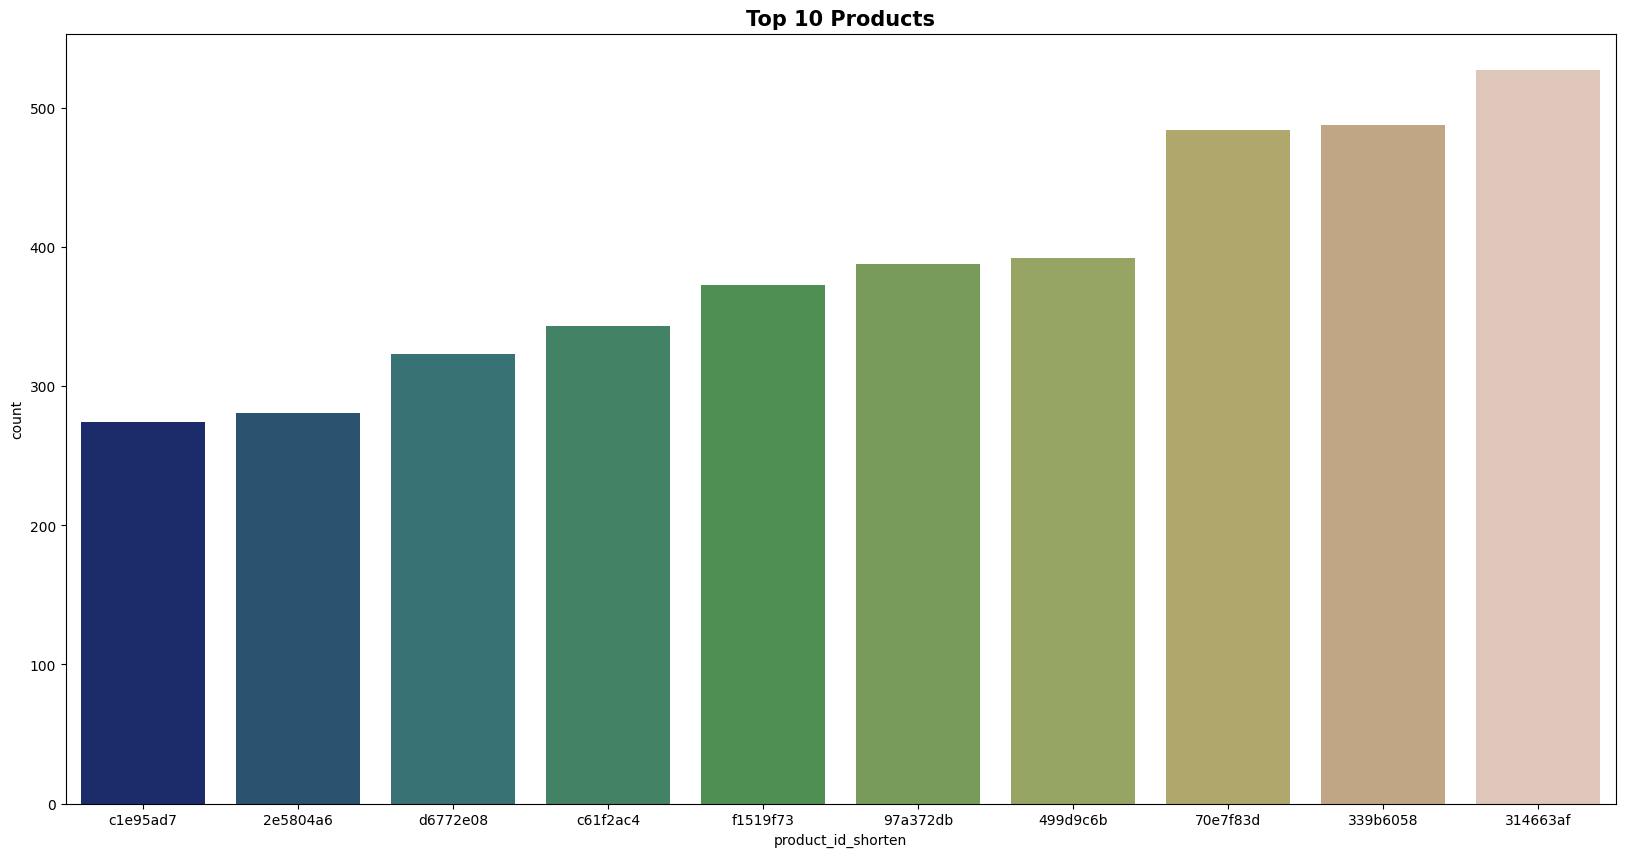

In [19]:
#Plotting Top 10 Products
plt.figure(figsize=(20,10))
sns.countplot(x='product_id_shorten', data=product_orders, palette='gist_earth',
             order=product_orders['product_id_shorten'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')

The above graph shows the Top 10 products. Top 3 products have a significant difference from the others. Because of the data information, we can't say about what are these products. But we can make an assumption regarding their category.

First Top 10 products' category shown below the table.

In [20]:
product_orders.groupby(["product_category_name"])["product_id_shorten"].count().sort_values(ascending=False).head(10)

product_category_name
cama_mesa_banho           11115
beleza_saude               9670
esporte_lazer              8641
moveis_decoracao           8334
informatica_acessorios     7827
utilidades_domesticas      6964
relogios_presentes         5991
telefonia                  4545
ferramentas_jardim         4347
automotivo                 4235
Name: product_id_shorten, dtype: int64

In [21]:
group_category= product_orders.groupby(['product_id_shorten','product_category_name',])['product_id_shorten']\
                                        .count().sort_values(ascending=False).head(10)
group_category

product_id_shorten  product_category_name 
314663af            moveis_decoracao          527
339b6058            cama_mesa_banho           488
70e7f83d            ferramentas_jardim        484
499d9c6b            ferramentas_jardim        392
97a372db            ferramentas_jardim        388
f1519f73            ferramentas_jardim        373
c61f2ac4            informatica_acessorios    343
d6772e08            relogios_presentes        323
2e5804a6            beleza_saude              281
c1e95ad7            informatica_acessorios    274
Name: product_id_shorten, dtype: int64

The top product category is `bed_table_bath`.
The top ordered product's category is `home decoration`

## Top 10 Seller

In [22]:
sellers_data = pd.read_csv(os.path.join(csv_path, 'olist_sellers_dataset.csv'))

First seller dataset will be merged with the product orders data.

In [23]:
seller_products = pd.merge(product_orders, sellers_data, on="seller_id")
seller_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  112650 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   delivered_time                 112650 non-null  object 
 9   estimate_time                  112650 non-null  object 
 10  weekly                         112650 non-null  int64  
 11  yearly                         112650 non-null  object 
 12  diff_days                     

As with the product id value name, the seller id name also needed to be shortened.

In [24]:
len(seller_products['seller_id'].unique())

3095

In [25]:
len(seller_products['seller_id'].str[-6:].unique())

3095

In [27]:
seller_products['seller_id_shorten']=seller_products['seller_id'].str[-6:]

Below pie chart shows the Top 10 Sellers. First 3 sellers have close proportions.

Text(0.5, 1.0, 'Top 10 Seller')

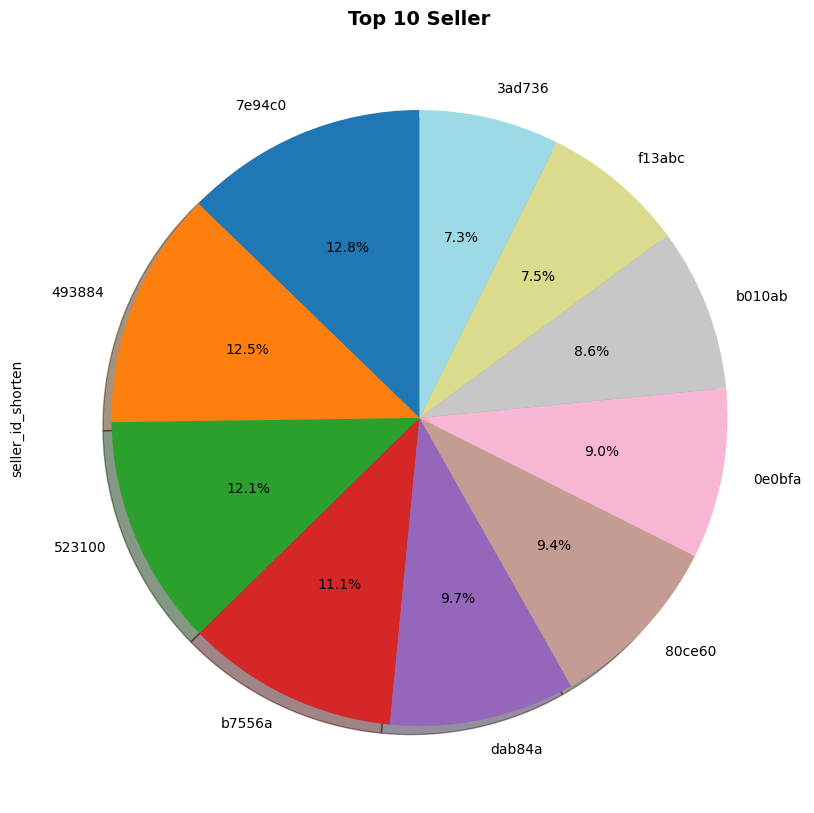

In [28]:
plt.figure(figsize=(20,10))
seller_products['seller_id_shorten'].value_counts()[:10].plot.pie(autopct='%1.1f%%',
        shadow=True, startangle=90, cmap='tab20')
plt.title("Top 10 Seller",size=14, weight='bold')

Assuming for the orders' product category of these sellers, we can use 'product category' values. Below table shows the Top 10 sellers category, and since they can sell multiple product types, garden tools are the most selling product of the best seller.

In [29]:
seller_category= seller_products.groupby(['seller_id_shorten', 'product_category_name'])\
                        ['seller_id_shorten'].count().sort_values(ascending=False).head(10)
seller_category

seller_id_shorten  product_category_name
523100             ferramentas_jardim       1882
7e94c0             relogios_presentes       1628
493884             cama_mesa_banho          1572
0e0bfa             moveis_decoracao         1292
dab84a             cama_mesa_banho          1277
b010ab             moveis_escritorio        1233
f13abc             telefonia                1178
b7556a             beleza_saude             1091
3ad736             cool_stuff               1069
3b52b2             relogios_presentes       1002
Name: seller_id_shorten, dtype: int64

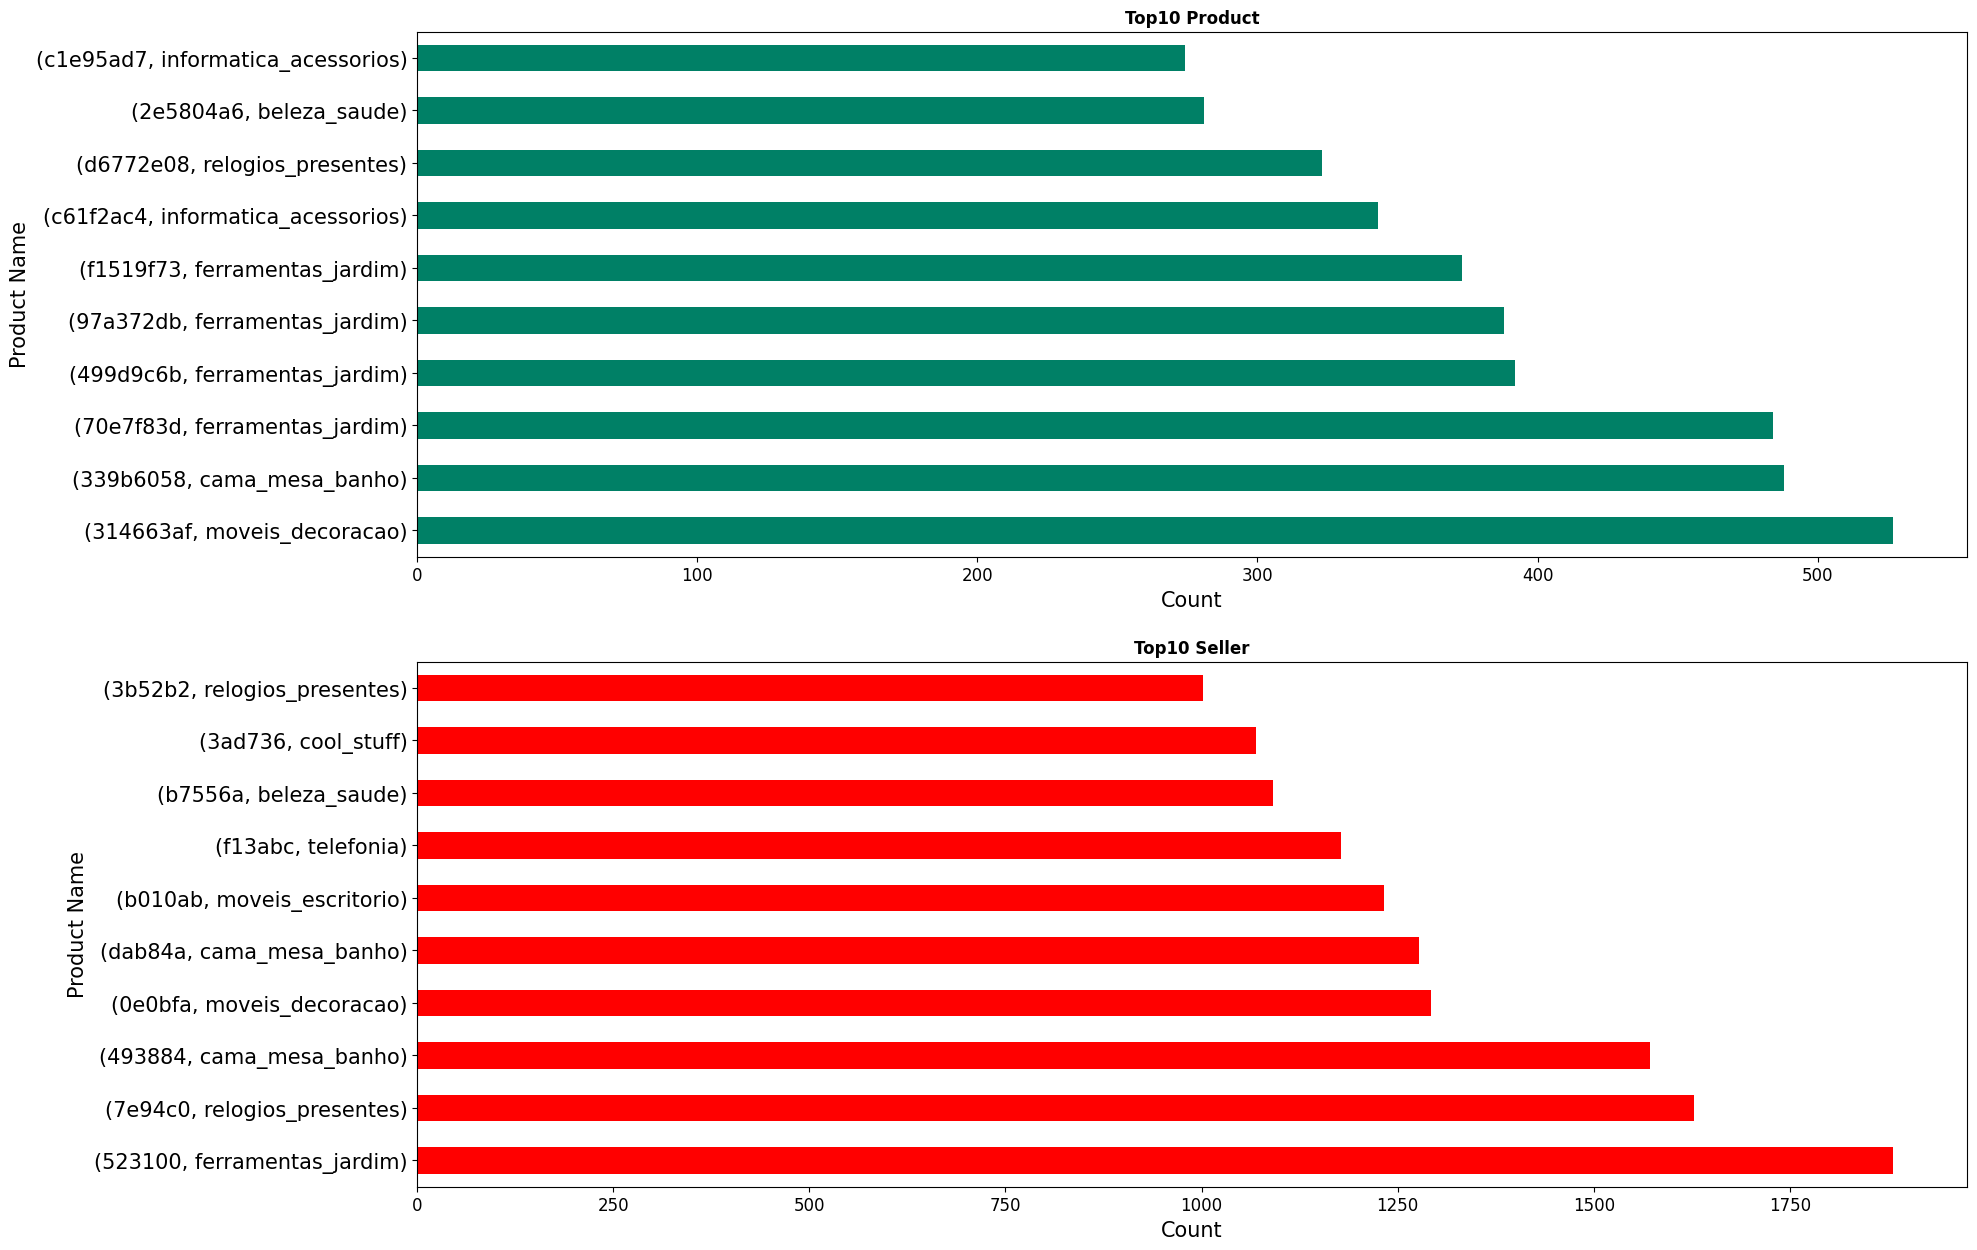

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
group_category.plot.barh(ax=ax1, cmap='summer')
seller_category.plot.barh(ax=ax2, cmap='autumn')

ax1.set_title('Top10 Product', fontweight='bold')
ax2.set_title('Top10 Seller', fontweight='bold')

ax1.set_xlabel('Count', fontsize=15)
ax1.set_ylabel('Product Name', fontsize=15)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=15)

ax2.set_xlabel('Count', fontsize=15)
ax2.set_ylabel('Product Name', fontsize=15)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=15)

Above graphs show the top products and top sellers category. While most selling product item belongs to the home decoration, most seller item belongs to garden tools.

Now, we can examine the most selling product's weekly purchased numbers, which is 314663af and belong to home decoration.

In [31]:
# First creating new feature of weeks
product_orders['order_week']= pd.to_datetime(product_orders['order_purchase_timestamp'],
                                            format='%Y-%m-%d').dt.week

/var/folders/wc/2q4dwnq93bj7t10_sww8jmv40000gn/T/ipykernel_12742/617530339.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  product_orders['order_week']= pd.to_datetime(product_orders['order_purchase_timestamp'],


In [36]:
#Weekly popular items 
items_weekly =product_orders.groupby(['order_week','product_category_name'])\
                        ['product_category_name'].count().sort_values(ascending=False)
#Change to data frame
most_products= items_weekly.reset_index(name='count')

In [37]:
#Find the max value of row
max_selling_products= most_products[most_products['count'] 
                            == most_products.groupby(['order_week'])\
                            ['count'].transform(max)]
max_selling_products.head(10)

,order_week,product_category_name,count
0,47,cama_mesa_banho,438
2,33,cama_mesa_banho,355
3,29,cama_mesa_banho,339
4,32,beleza_saude,330
5,8,informatica_acessorios,330
8,31,beleza_saude,320
9,9,informatica_acessorios,314
10,19,beleza_saude,310
11,18,beleza_saude,302
12,23,cama_mesa_banho,301


In [38]:
max_selling_products['product_category_name'].value_counts()

cama_mesa_banho           33
beleza_saude              10
informatica_acessorios     3
esporte_lazer              3
moveis_decoracao           2
brinquedos                 1
Name: product_category_name, dtype: int64

Above table shows that 33 of 52 weeks the most selling's product is bed_table_bath. This category is in the top 3 either most selling product group or most sellers group.

## Payments

Last data exploratory is about payments.

In [42]:
payment_data = pd.read_csv(os.path.join(csv_path, 'olist_order_payments_dataset.csv'))

In [43]:
payments=pd.merge(seller_products, payment_data, on="order_id")
payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117601 non-null  object 
 1   customer_id                    117601 non-null  object 
 2   order_status                   117601 non-null  object 
 3   order_purchase_timestamp       117601 non-null  object 
 4   order_approved_at              117586 non-null  object 
 5   order_delivered_carrier_date   116356 non-null  object 
 6   order_delivered_customer_date  117601 non-null  object 
 7   order_estimated_delivery_date  117601 non-null  object 
 8   delivered_time                 117601 non-null  object 
 9   estimate_time                  117601 non-null  object 
 10  weekly                         117601 non-null  int64  
 11  yearly                         117601 non-null  object 
 12  diff_days                     

In [44]:
#First drop irrelevant columns that to make more handy to data
payments= payments.drop(columns=['product_name_lenght','product_description_lenght',
                                 'product_photos_qty','product_weight_g','product_length_cm',
                                 'product_height_cm','product_width_cm'])

In [45]:
price_details= payments.groupby(['order_id','price','product_category_name',
                                 'yearly','weekly'])[['freight_value','payment_value']].sum().reset_index()

As written on the data description, `total order value` can be calculated by sum of `price` and `freight value`.

In [46]:
price_details['total_order_value'] = price_details['price'] + price_details['freight_value']

We can calculate `Gross Profit` and `Profit Margin` using `payment value` and `total order value`.

In [47]:
price_details['gross_profit'] = price_details['payment_value']- price_details['total_order_value']
price_details['profit_margin'] = price_details['gross_profit']/price_details['payment_value']
price_details['profit_margin'] = price_details['profit_margin'].astype('int64')

In [48]:
price_details.sort_values('gross_profit', ascending=False).head(10)

,order_id,price,product_category_name,yearly,weekly,freight_value,payment_value,total_order_value,gross_profit,profit_margin
1466,03caa2c082116e1d31e67e9ae3700499,1680.00,telefonia_fixa,2017-10,42,224.08,109312.64,1904.08,107408.56,0
66523,ab14fdcfbe524636d65ee38360e22ce8,98.70,automotivo,2017-09,35,288.80,45256.00,387.50,44868.50,0
10548,1b15974a0141d54e36626dca3fdc731a,100.00,informatica_acessorios,2018-03,10,202.40,44048.00,302.40,43745.60,0
17262,2cc9089445046817a7539d90805e6e5a,989.10,agro_industria_e_comercio,2017-12,50,146.94,36489.24,1136.04,35353.20,0
90941,e8fa22c3673b1dd17ea315021b1f0f61,284.99,bebidas,2018-05,18,168.70,30186.00,453.69,29732.31,0
44991,736e1922ae60d0d6a89247b851902527,1790.00,telefonia_fixa,2018-07,30,114.88,29099.52,1904.88,27194.64,0
25844,428a2f660dc84138d969ccd69a0ab6d5,65.49,moveis_decoracao,2017-12,50,243.30,18384.75,308.79,18075.96,0
22593,3a213fcdfe7d98be74ea0dc05a8b31ae,108.00,relogios_presentes,2018-01,4,186.24,17786.88,294.24,17492.64,0
96747,f80549a97eb203e1566e026ab66f045b,137.90,informatica_acessorios,2017-09,39,388.10,17671.00,526.00,17145.00,0
26447,4412d97cb2093633afa85f11db46316c,120.00,informatica_acessorios,2018-06,23,83.99,15978.65,203.99,15774.66,0


Text(0.5, 1.0, 'Gross Profit of Top 5 Products (2016-2018)')

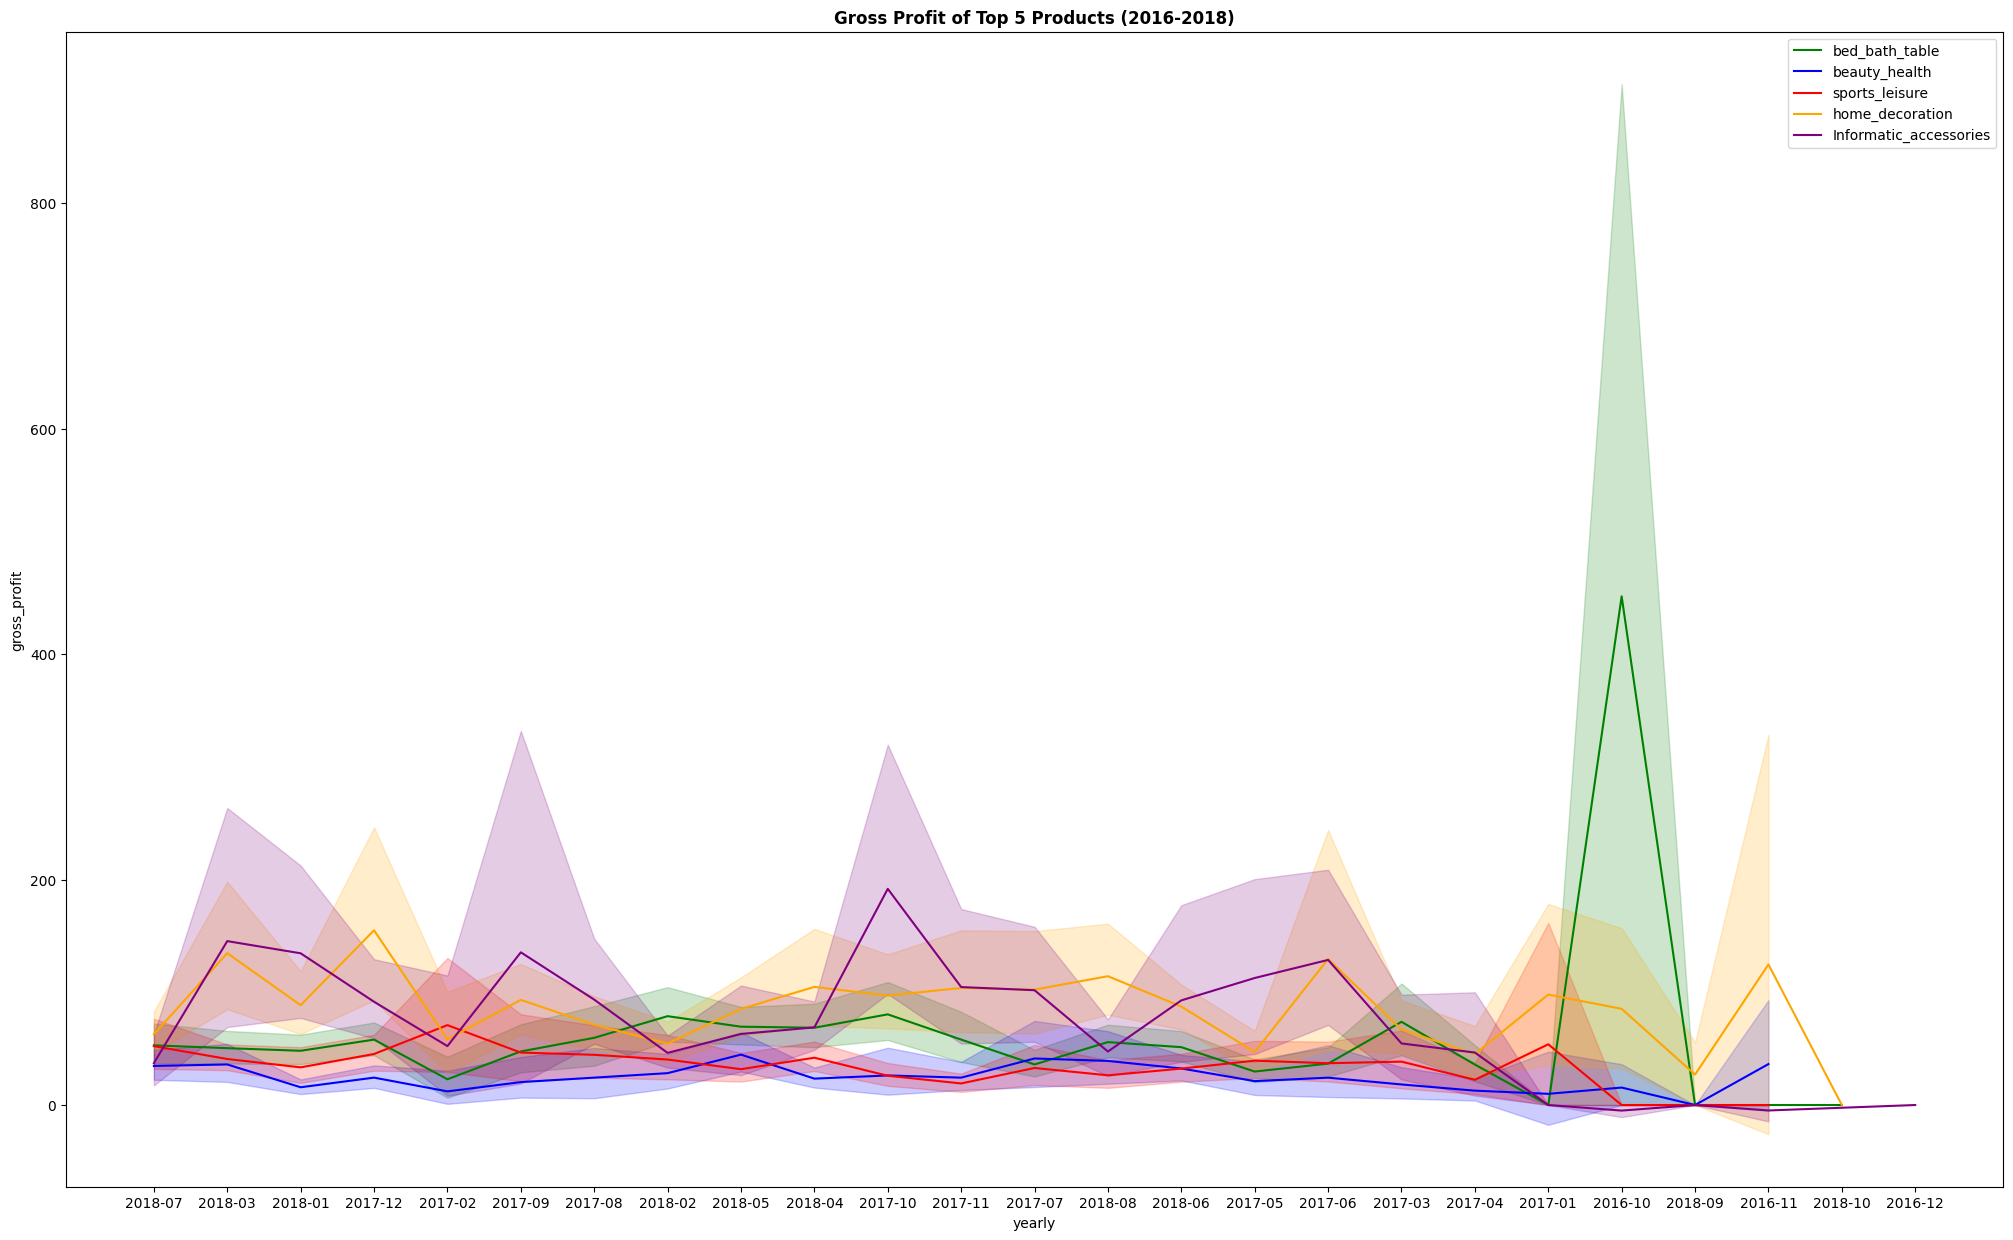

In [49]:
plt.figure(figsize=(25,15))

sns.lineplot(x='yearly',y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='cama_mesa_banho'], label='bed_bath_table',color="green")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='beleza_saude'], label='beauty_health', color="blue")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='esporte_lazer'], label='sports_leisure', color="red")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='moveis_decoracao'], label='home_decoration', color="orange")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='informatica_acessorios'], label='Informatic_accessories', color="purple")
plt.title("Gross Profit of Top 5 Products (2016-2018)",fontweight='bold')

Above graph shows yearly 'gross profit' distribution for the top 5 product category of ordered products and sellers. According to data, we can say that `informatic_accessories` have the highest `gross profit` in Agust 2017 to November 2017. On the other hand, the top 3 products'(`bed_bath_table`, `beauty_health` and `sports_leisure`) gross profits are less than 200 units of currency.

# Conclusion

The aim of this project was to find the Top 10 products and sellers, analysis of orders by their geolocation and obtain information about Brazilian's online e-commerce profiles to assist decision makers in the Brazilian e-commerce market or anyone interested in the Brazilian e-commerce market by using one of the biggest e-commerce merchant's data.